# Introduction to JPEG Compression: Practical tools

**Author:** Martin Beneš

## Notebook setup

First, install `jpeglib` package.

In [1]:
!pip install jpeglib  # install dependencies

We use again `00001.tif` from ALASKA database as a sample image.

In [2]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## In JPEG we can work losslessly with DCT coefficients.

We start with JPEG-compressed file `cover_qf75.jpeg`.

In [3]:
import jpeglib
import numpy as np
from PIL import Image
RGB = np.array(Image.open('00001.tif'))  # load RGB
jpeglib.from_spatial(RGB).write_spatial('cover_qf75.jpeg', qt=75)  # compress with JPEG

DCT coefficients denote the contribution of each frequency to the pixel block. $8x8$ DCT block denotes following frequencies. These frequencies are also called subbands.

<img src="https://github.com/uibk-uncover/prague-jpeg-demo/blob/main/img/dct.png?raw=true" style="height: 25em"/>

We can losslessly read and write DCT coefficients.

In [4]:
jpeg = jpeglib.read_dct('cover_qf75.jpeg')  # read JPEG in DCT domain

The luminance tensor can be accessed with `Y`. Original $512\times512$ image is split into $64\times64$ pixel blocks, each consisting of $8\times8$ pixels (because $\frac{512}{8}=64$).

In [5]:
jpeg.Y  # luminance blocks

array([[[[ -18,   -5,   -6, ...,    0,    0,    0],
         [   4,   -1,    2, ...,    0,    0,    0],
         [   1,    0,    1, ...,    0,    0,    0],
         ...,
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0]],

        [[ -10,    0,    1, ...,    0,    0,    0],
         [   8,    5,   -6, ...,    0,    0,    0],
         [  -3,    0,    1, ...,    0,    0,    0],
         ...,
         [  -1,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0]],

        [[  -4,   -2,    8, ...,    0,    0,    0],
         [   0,   -1,   -2, ...,    0,    0,    0],
         [   1,    0,   -1, ...,    0,    0,    0],
         ...,
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0]],

        ...,

  

In [6]:
jpeg.Y.shape

(64, 64, 8, 8)

This is obtain the top-left luminance $8\times8$ block as follows.

In [7]:
jpeg.Y[0, 0]  # top-left block of luminance

array([[-18,  -5,  -6,   0,   0,   0,   0,   0],
       [  4,  -1,   2,  -1,   1,   0,   0,   0],
       [  1,   0,   1,  -1,   0,   0,   0,   0],
       [  3,  -1,  -1,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=int16)

The subbands, e.g. 01, can be acquired by a simple expression.

In [8]:
jpeg.Y[:, :, 0, 1]  # 01 subband of luminance

array([[ -5,   0,  -2, ...,  -2,   6, -17],
       [ -7,   1,   3, ..., -44,  55,   6],
       [-13,   9,  -5, ...,  27,   9,  -4],
       ...,
       [ 48,  -7,   4, ...,   3,  11,  -3],
       [ 35,   3,   6, ...,  11,   1,  -2],
       [ 29,   2,   5, ...,  13,   0,   1]], dtype=int16)

Subband 00 is called DC, all the others are called AC.

## Chrominance is often subsampled.

Get the chrominance (red and blue) with `Cb` and `Cr`.

In [9]:
jpeg.Cb.shape

(32, 32, 8, 8)

In [10]:
jpeg.Cr.shape

(32, 32, 8, 8)

You get the top-left chrominance $8\times8$ block similarly to before.

In [11]:
jpeg.Cb[0, 0]  # top-left block of blue chrominance

array([[-13,  -4,  -2,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [ -1,   2,   0,   0,   0,   0,   0,   0],
       [  0,  -1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=int16)

The chrominance channels are often subsampled, which further reduces the file size.

The sampling factor can be derived from the shapes, or accessed directly as `samp_factor`.

In [12]:
jpeg.Cb.shape[0] / jpeg.Y.shape[0]

0.5

In [13]:
jpeg.samp_factor  # sampling factors of chrominances

array([[2, 2],
       [1, 1],
       [1, 1]], dtype=int32)

## Quality factor is an abstraction for a quantization table (QT).

The quantization tables can be accessed via the image's `qt` property.

In [14]:
jpeg.qt  # quantization tables at QF75

array([[[ 8,  6,  5,  8, 12, 20, 26, 31],
        [ 6,  6,  7, 10, 13, 29, 30, 28],
        [ 7,  7,  8, 12, 20, 29, 35, 28],
        [ 7,  9, 11, 15, 26, 44, 40, 31],
        [ 9, 11, 19, 28, 34, 55, 52, 39],
        [12, 18, 28, 32, 41, 52, 57, 46],
        [25, 32, 39, 44, 52, 61, 60, 51],
        [36, 46, 48, 49, 56, 50, 52, 50]],

       [[ 9,  9, 12, 24, 50, 50, 50, 50],
        [ 9, 11, 13, 33, 50, 50, 50, 50],
        [12, 13, 28, 50, 50, 50, 50, 50],
        [24, 33, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50]]], dtype=uint16)

There are two quantization tables for three components (Y, Cb, Cr). Cb and Cr components can share the same quantization table.

In [15]:
jpeg.quant_tbl_no  # assignment of quantization tables

array([0, 1, 1])

In some implementations, the quality factor basically scales the quantization table. A high quality factor leads to small-valued quantization tables. A lower quality factor corresponds to more quantization, i.e., higher quantization table entries.

In [16]:
jpeglib.from_spatial(RGB).write_spatial('cover_qf90.jpeg', qt=90)  # compress with JPEG at QF90
jpeg_q90 = jpeglib.read_dct('cover_qf90.jpeg')  # read JPEG DCT
jpeg_q90.qt  # QT at QF90

array([[[ 3,  2,  2,  3,  5,  8, 10, 12],
        [ 2,  2,  3,  4,  5, 12, 12, 11],
        [ 3,  3,  3,  5,  8, 11, 14, 11],
        [ 3,  3,  4,  6, 10, 17, 16, 12],
        [ 4,  4,  7, 11, 14, 22, 21, 15],
        [ 5,  7, 11, 13, 16, 21, 23, 18],
        [10, 13, 16, 17, 21, 24, 24, 20],
        [14, 18, 19, 20, 22, 20, 21, 20]],

       [[ 3,  4,  5,  9, 20, 20, 20, 20],
        [ 4,  4,  5, 13, 20, 20, 20, 20],
        [ 5,  5, 11, 20, 20, 20, 20, 20],
        [ 9, 13, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20]]], dtype=uint16)

A higher quality factor means the values in quantization become lower.

In [17]:
jpeglib.from_spatial(RGB).write_spatial('cover_qf100.jpeg', qt=100)  # compress with JPEG at QF100
jpeg_q100 = jpeglib.read_dct('cover_qf100.jpeg')  # read JPEG DCT
jpeg_q100.qt  # QT at QF100

array([[[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]]], dtype=uint16)

Quality factor 100 correspond to QTs with all ones.

## DCT coefficients follow a Laplace distribution

The distribution of DCT coefficients is symmetric around $0$ and usually follows a Laplace distribution.

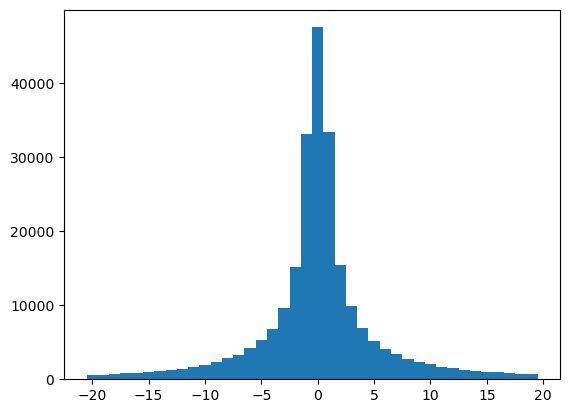

In [18]:
import matplotlib.pyplot as plt
N = 40
plt.hist(jpeg_q100.Y.flatten(), bins=N, range=(-N//2-.5, N//2-.5));

At lower QFs, we observe much more zeros.

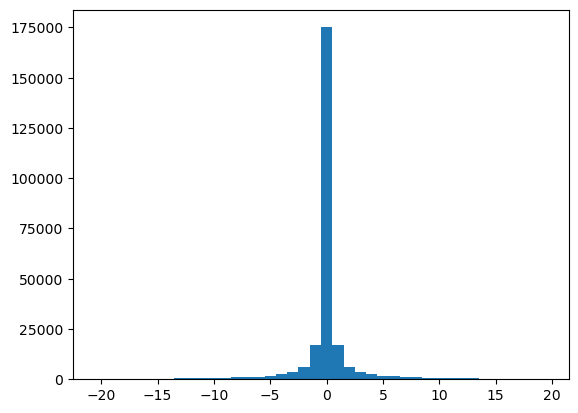

In [19]:
N = 40
plt.hist(jpeg_q90.Y.flatten(), bins=N, range=(-N//2-.5, N//2-.5));

## Hands-on: Double compression

- What can you spot in DCT histogram of a double-compressed image?